# LSTM models

In this notebook we will present the LSTM model and compare how the different vectorization methods perform with it.

First of all, we load our preprocessed dataset and do all the different vectorizations.


In [1]:
# Data handling
import numpy as np
import pandas as pd

# Text processing
import re
import string
import emoji
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from gensim import models
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import multiprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

In [4]:
df = pd.read_csv("../DATASETS/preprocessed_text.csv")

In [5]:
df.isnull().sum()
df.fillna('', inplace=True)

In [13]:
df.head()

,Content,Score,Sentiment,Content_cleaned
0,Plsssss stoppppp giving screen limit like when...,2,negative,plss stopp giving screen limit like when you a...
1,Good,5,positive,good
2,👍👍,5,positive,thumbs_up thumbs_up
3,Good,3,neutral,good
4,"App is useful to certain phone brand ,,,,it is...",1,negative,app is useful to certain phone brand it is not...


In [14]:
def get_average_word2vec2(tokens_list, model, vector_size):
    valid_tokens = [token for token in tokens_list if token in model.wv]
    if not valid_tokens:
        return np.zeros(vector_size)
    word_vectors = [model.wv[token] for token in valid_tokens]
    average_vector = np.mean(word_vectors, axis=0)
    return average_vector

# Define model parameters
vector_size = 300   # Dimensionality of the word vectors
window_size = 5     # Context window size
min_count = 1       # Minimum word frequency
workers = multiprocessing.cpu_count()  # Number of worker threads to use

df['tokens'] = df['Content_cleaned'].apply(lambda x: x.split())


# Train the Word2Vec model
cbow = models.Word2Vec(df['tokens'].tolist(), vector_size=vector_size, sg=0, window=window_size, min_count=min_count, workers=workers)

df['word2vec_cbow'] = df['tokens'].apply(lambda x: get_average_word2vec2(x, cbow, vector_size))

df.head()

,Content,Score,Sentiment,Content_cleaned,tokens,word2vec_cbow
0,Plsssss stoppppp giving screen limit like when...,2,negative,plss stopp giving screen limit like when you a...,"[plss, stopp, giving, screen, limit, like, whe...","[0.17334877, -0.28255883, -0.4027487, 0.146065..."
1,Good,5,positive,good,[good],"[-0.5031254, 0.6095891, -0.30126148, 1.342169,..."
2,👍👍,5,positive,thumbs_up thumbs_up,"[thumbs_up, thumbs_up]","[-0.2885525, 0.5973266, -0.42874572, 0.2057450..."
3,Good,3,neutral,good,[good],"[-0.5031254, 0.6095891, -0.30126148, 1.342169,..."
4,"App is useful to certain phone brand ,,,,it is...",1,negative,app is useful to certain phone brand it is not...,"[app, is, useful, to, certain, phone, brand, i...","[-0.030504113, -0.7375741, -0.27401972, 0.0877..."


### Models

In RNN, BoW and TFIDF are not used. Instead the sequences are tokenized and paded and the embeddings are either learned by the network or are given to them as pretrained, like glove or w2v embeddings. We will try one model that learns its own embeddings, one w2v model and one glove model.

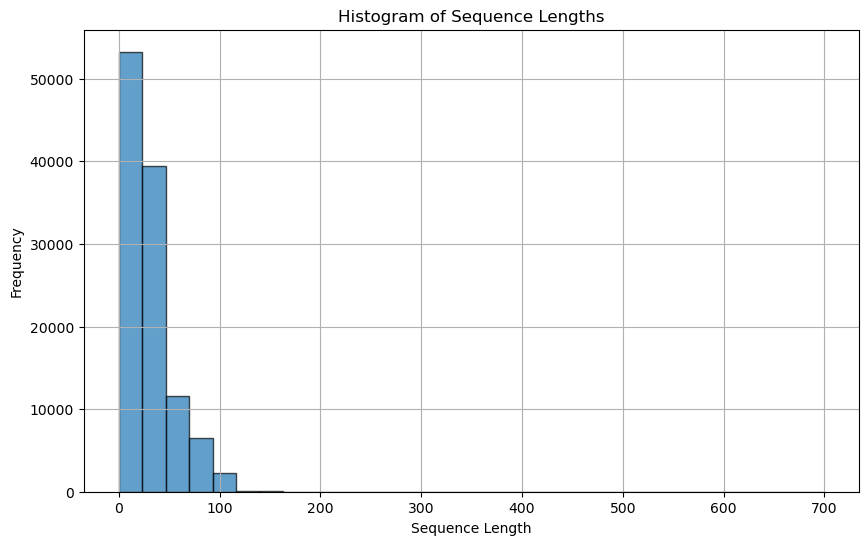

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Tokenize and pad the text data
MAX_NB_WORDS = 50000

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True)
tokenizer.fit_on_texts(df['Content_cleaned'].values)
word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(df['Content_cleaned'].values)

sequence_lengths = [len(sequence) for sequence in sequences]

# Plot histogram of sequence lengths
plt.figure(figsize=(10, 6))
plt.hist(sequence_lengths, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Histogram of Sequence Lengths')
plt.grid(True)
plt.show()

We notice that the majority of our inputs are up to 150 sequence length, therefore we will pad to 170, to contain some edge cases.

In [8]:
from keras.callbacks import LearningRateScheduler

MAX_SEQUENCE_LENGTH = 170
EMBEDDING_DIM = 100

X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

# Encode the target variable
le = LabelEncoder()
y = le.fit_transform(df['Sentiment'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the RNN model
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(len(le.classes_), activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the model
epochs = 6
batch_size = 128

# Define a function to change the learning rate
def scheduler(epoch, lr):
    if epoch < 3:
        return 0.001
    else:
        return 0.0003

# Use the LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(scheduler)

early_stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='min', restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[early_stopping, lr_scheduler], verbose=1)

# Make predictions
y_pred = model.predict(X_test, batch_size=batch_size, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_classes)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred_classes))

Epoch 1/6
709/709 ━━━━━━━━━━━━━━━━━━━━ 137s 191ms/step - accuracy: 0.7170 - loss: 0.7068 - val_accuracy: 0.8050 - val_loss: 0.5429 - learning_rate: 0.0010
Epoch 2/6
709/709 ━━━━━━━━━━━━━━━━━━━━ 133s 188ms/step - accuracy: 0.8107 - loss: 0.5180 - val_accuracy: 0.8101 - val_loss: 0.5158 - learning_rate: 0.0010
Epoch 3/6
709/709 ━━━━━━━━━━━━━━━━━━━━ 136s 192ms/step - accuracy: 0.8218 - loss: 0.4766 - val_accuracy: 0.8106 - val_loss: 0.5187 - learning_rate: 0.0010
Epoch 4/6
709/709 ━━━━━━━━━━━━━━━━━━━━ 134s 189ms/step - accuracy: 0.8377 - loss: 0.4296 - val_accuracy: 0.8032 - val_loss: 0.5313 - learning_rate: 3.0000e-04
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 2.
178/178 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step
Accuracy: 0.8100534004148462
              precision    recall  f1-score   support

           0       0.80      0.93      0.86     11152
           1       0.37      0.04      0.08      2318
           2       0.84      0.85      0.85      9189

   

In the traditional machine learning models we noticed that our custom trained Word2Vec model outperformed the pretrained one in all cases, so we will proceed in testing only that one.

In [15]:
word2vec_model = cbow #models.KeyedVectors.load_word2vec_format('../GoogleNews-vectors-negative300.bin', binary=True)

# Tokenize and pad the text data
MAX_SEQUENCE_LENGTH = 170
EMBEDDING_DIM = 300  # Word2Vec model dimension

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Content_cleaned'].values)
word_index = tokenizer.word_index

X = tokenizer.texts_to_sequences(df['Content_cleaned'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

# Encode the target variable
le = LabelEncoder()
y = le.fit_transform(df['Sentiment'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the embedding matrix
num_words = min(len(word_index) + 1, len(word2vec_model.wv.index_to_key))
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i >= num_words:
        continue
    try:
        embedding_vector = word2vec_model.wv[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i] = np.zeros(EMBEDDING_DIM)

# Build the RNN model
model = Sequential()
model.add(Embedding(num_words, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(len(le.classes_), activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the model
epochs = 6
batch_size = 128

# Define a function to change the learning rate
def scheduler(epoch, lr):
    if epoch < 3:
        return 0.001
    else:
        return 0.0003

# Use the LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(scheduler)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min', restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[early_stopping, lr_scheduler], verbose=1)

# Make predictions
y_pred = model.predict(X_test, batch_size=batch_size, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_classes)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred_classes))

Epoch 1/6


C:\Users\geoch\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


709/709 ━━━━━━━━━━━━━━━━━━━━ 141s 196ms/step - accuracy: 0.7453 - loss: 0.6686 - val_accuracy: 0.8001 - val_loss: 0.5379 - learning_rate: 0.0010
Epoch 2/6
709/709 ━━━━━━━━━━━━━━━━━━━━ 142s 200ms/step - accuracy: 0.7967 - loss: 0.5444 - val_accuracy: 0.8096 - val_loss: 0.5135 - learning_rate: 0.0010
Epoch 3/6
709/709 ━━━━━━━━━━━━━━━━━━━━ 141s 199ms/step - accuracy: 0.8056 - loss: 0.5229 - val_accuracy: 0.8113 - val_loss: 0.5080 - learning_rate: 0.0010
Epoch 4/6
709/709 ━━━━━━━━━━━━━━━━━━━━ 141s 199ms/step - accuracy: 0.8107 - loss: 0.5089 - val_accuracy: 0.8134 - val_loss: 0.5007 - learning_rate: 3.0000e-04
Epoch 5/6
709/709 ━━━━━━━━━━━━━━━━━━━━ 144s 203ms/step - accuracy: 0.8117 - loss: 0.5016 - val_accuracy: 0.8148 - val_loss: 0.4990 - learning_rate: 3.0000e-04
Epoch 6/6
709/709 ━━━━━━━━━━━━━━━━━━━━ 144s 203ms/step - accuracy: 0.8128 - loss: 0.4970 - val_accuracy: 0.8138 - val_loss: 0.4982 - learning_rate: 3.0000e-04
Restoring model weights from the end of the best epoch: 6.
178/178 ━

In [19]:
# Path to the GloVe embeddings file
glove_file = '../../glove.twitter.27B.100d.txt'

# Load the GloVe embeddings into a dictionary
def load_glove_embeddings(glove_file):
    embeddings_index = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

# Load the GloVe embeddings
embeddings_index  = load_glove_embeddings(glove_file)

# Tokenize and pad the text data
MAX_SEQUENCE_LENGTH = 200
EMBEDDING_DIM = 100  # Word2Vec model dimension

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Content_cleaned'].values)
word_index = tokenizer.word_index

X = tokenizer.texts_to_sequences(df['Content_cleaned'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

# Encode the target variable
le = LabelEncoder()
y = le.fit_transform(df['Sentiment'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the embedding matrix
num_words = min(len(word_index) + 1, len(embeddings_index))
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
        
for word, i in word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
# Build the RNN model
model = Sequential()
model.add(Embedding(num_words, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(len(le.classes_), activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Train the model
epochs = 8
batch_size = 128

# Define a function to change the learning rate
def scheduler(epoch, lr):
    if epoch < 3:
        return 0.001
    else:
        return 0.0003

# Use the LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(scheduler)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min', restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[early_stopping, lr_scheduler], verbose=1)

# Make predictions
y_pred = model.predict(X_test, batch_size=batch_size, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_classes)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred_classes))

Epoch 1/8


C:\Users\geoch\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


709/709 ━━━━━━━━━━━━━━━━━━━━ 167s 233ms/step - accuracy: 0.6967 - loss: 0.7583 - val_accuracy: 0.7886 - val_loss: 0.5771 - learning_rate: 0.0010
Epoch 2/8
709/709 ━━━━━━━━━━━━━━━━━━━━ 150s 211ms/step - accuracy: 0.7730 - loss: 0.6122 - val_accuracy: 0.7997 - val_loss: 0.5474 - learning_rate: 0.0010
Epoch 3/8
709/709 ━━━━━━━━━━━━━━━━━━━━ 151s 213ms/step - accuracy: 0.7850 - loss: 0.5824 - val_accuracy: 0.8032 - val_loss: 0.5315 - learning_rate: 0.0010
Epoch 4/8
709/709 ━━━━━━━━━━━━━━━━━━━━ 160s 226ms/step - accuracy: 0.7937 - loss: 0.5578 - val_accuracy: 0.8056 - val_loss: 0.5254 - learning_rate: 3.0000e-04
Epoch 5/8
709/709 ━━━━━━━━━━━━━━━━━━━━ 175s 247ms/step - accuracy: 0.7924 - loss: 0.5576 - val_accuracy: 0.8066 - val_loss: 0.5215 - learning_rate: 3.0000e-04
Epoch 6/8
709/709 ━━━━━━━━━━━━━━━━━━━━ 157s 222ms/step - accuracy: 0.7923 - loss: 0.5581 - val_accuracy: 0.8058 - val_loss: 0.5245 - learning_rate: 3.0000e-04
Epoch 7/8
709/709 ━━━━━━━━━━━━━━━━━━━━ 159s 224ms/step - accuracy: 0